# Training pipeline

Creating a model to predict premier league player score with previous created feature group

# Imports

In [2]:
# imports
import os
import sys
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from importlib import reload

from functions import util

import warnings
warnings.filterwarnings("ignore")

## Connect to Hopsworks feature store

In [3]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
with open('./hopsworks/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
print(project.description)

2025-01-03 16:11:40,432 INFO: Initializing external client
2025-01-03 16:11:40,434 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-03 16:11:42,187 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159321
Default project


In [4]:
fs = project.get_feature_store()

# Retrieve feature group
player_fg = fs.get_feature_group(
    name='player_features',
    version=1,
)

# Create feature view

In [5]:
# Select features
selected_features = player_fg.select_all()
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.70s) 


,id,total_points,gameweek,prev_minutes,prev_goals_scored,prev_assists,prev_clean_sheets,prev_goals_conceded,prev_own_goals,prev_penalties_saved,...,prev_influence,prev_creativity,prev_threat,prev_ict_index,prev_starts,prev_expected_goals,prev_expected_assists,prev_expected_goal_involvements,prev_expected_goals_conceded,prev_in_dreamteam
0,74,3,18,90.0,0.0,1.0,1.0,0.0,0.0,0.0,...,37.2,21.6,8.0,6.7,1.0,0.00,0.26,0.26,2.26,0.0
1,410,1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
2,208,0,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
3,184,1,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
4,659,0,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
5,340,0,13,90.0,0.0,0.0,0.0,4.0,0.0,0.0,...,11.4,4.1,11.0,2.7,1.0,0.08,0.03,0.11,2.51,0.0
6,388,2,4,90.0,0.0,0.0,0.0,3.0,0.0,0.0,...,20.4,30.8,0.0,5.1,1.0,0.00,0.05,0.05,3.00,0.0
7,327,1,14,90.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2.0,13.1,4.0,1.9,1.0,0.00,0.11,0.11,0.77,0.0
8,377,2,16,25.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.2,10.5,0.0,1.8,0.0,0.00,0.01,0.01,0.00,0.0
9,586,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0


In [6]:
# Create feature view
feature_view = fs.get_or_create_feature_view(
    name='player_score_fv',
    description="player data with score label",
    version=1,
    labels=['total_points'],
    query=selected_features,
)

# Split data into training and test set

In [7]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=0.2
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.88s) 


In [8]:
X_train

,id,gameweek,prev_minutes,prev_goals_scored,prev_assists,prev_clean_sheets,prev_goals_conceded,prev_own_goals,prev_penalties_saved,prev_penalties_missed,...,prev_influence,prev_creativity,prev_threat,prev_ict_index,prev_starts,prev_expected_goals,prev_expected_assists,prev_expected_goal_involvements,prev_expected_goals_conceded,prev_in_dreamteam
0,74,18,90.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,37.2,21.6,8.0,6.7,1.0,0.00,0.26,0.26,2.26,0.0
2,208,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
3,184,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
8,377,16,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.2,10.5,0.0,1.8,0.0,0.00,0.01,0.01,0.00,0.0
10,88,19,90.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,10.0,0.8,6.0,1.7,1.0,0.12,0.00,0.12,1.29,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12091,258,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
12093,472,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
12094,50,2,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.2,0.3,0.0,0.5,0.0,0.00,0.00,0.00,1.04,0.0
12095,590,17,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.2,10.3,0.0,1.2,0.0,0.00,0.02,0.02,0.00,0.0


In [9]:
# Drop the index columns - 'id' (event_time) and 'gameweek' (primary key)

train_features = X_train.drop(['id', 'gameweek'], axis=1)
test_features = X_test.drop(['id', 'gameweek'], axis=1)

In [10]:
y_train

,total_points
0,3
2,0
3,1
8,2
10,0
...,...
12091,0
12093,0
12094,1
12095,0


# Modeling

In [11]:
# Convert all object types to float
for col in train_features.columns:
    if train_features[col].dtype == 'object':
        train_features[col] = train_features[col].astype('float64')

for col in test_features.columns:
    if test_features[col].dtype == 'object':
        test_features[col] = test_features[col].astype('float64')

print(train_features.dtypes)

prev_minutes                       float64
prev_goals_scored                  float64
prev_assists                       float64
prev_clean_sheets                  float64
prev_goals_conceded                float64
prev_own_goals                     float64
prev_penalties_saved               float64
prev_penalties_missed              float64
prev_yellow_cards                  float64
prev_red_cards                     float64
prev_saves                         float64
prev_bonus                         float64
prev_bps                           float64
prev_influence                     float64
prev_creativity                    float64
prev_threat                        float64
prev_ict_index                     float64
prev_starts                        float64
prev_expected_goals                float64
prev_expected_assists              float64
prev_expected_goal_involvements    float64
prev_expected_goals_conceded       float64
prev_in_dreamteam                  float64
dtype: obje

In [12]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 5.283808613139771
R squared: 0.10396566743325975


In [14]:
df = y_test
df['predicted_score'] = y_pred

In [15]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "player_score_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

Saving plot to: player_score_model/images/player_score_hindcast.png
   total_points  predicted_score
1             1         0.214927
4             0         0.214927
5             0         1.228349
6             2         2.028954
7             1         6.216568


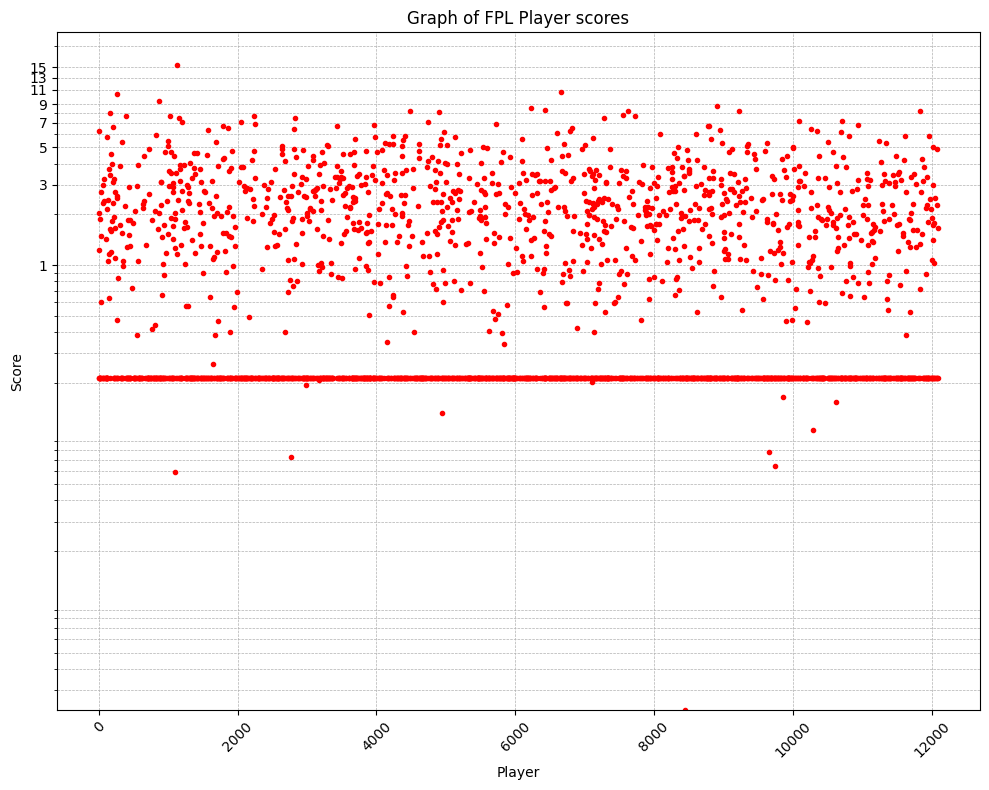

In [ ]:
# Reload file to get the latest changes, it was not updating the changes otherwise
reload(util)

file_path = images_dir + "/player_score_hindcast.png"
print("Saving plot to:", file_path)

# print(df.head())

plt = util.plot_player_score_forecast("FPL Player scores", df, file_path, hindcast=False)
plt.show()

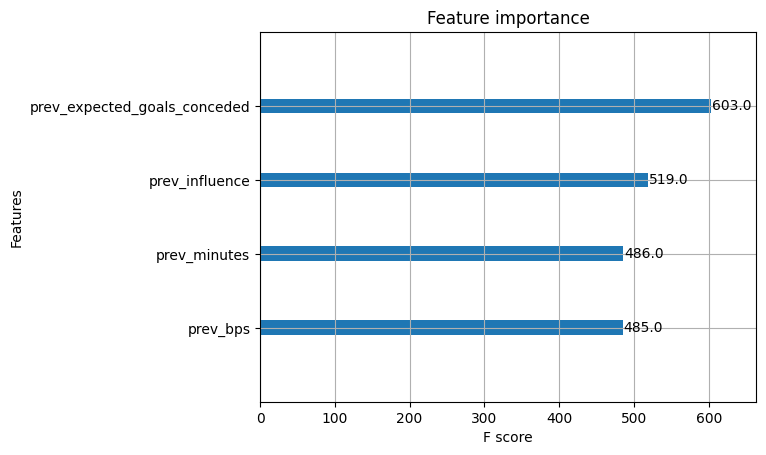

In [23]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

# Model registry

In [18]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [19]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [20]:
res_dict = {
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [21]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="player_score_xgboost_model",
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Player score predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/499456 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19030 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/82834 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/130 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2252 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1159321/models/player_score_xgboost_model/1


Model(name: 'player_score_xgboost_model', version: 1)